# Тема работы: статистический анализ больших наборов текстовой информации

### Цель работы: выявление схожих черт и отличительных особеностей среди сообщений со спамом и сообщений без него и обучение моделей классификации сообщений на спам/не спам.

### **Структура работы:** 

1. Загрузка необходимых библиотек 
2. Загрузка датасета и анализ основных характеристик
3. Частотный анализ данных
4. Очистка данных и частотный анализ данных после предобработки
5. Векторизация текста 
6. Разбиение данных на обучающую, тестовую выборки 
7. Обучение моделей классификации 
8. Выводы о проделанных алгоритмах, выбор наиболее эффективного 
89. Визуализация результатов

1. Заргрузим необходимые библиотеки

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import nltk

2. Загрузим датасет:

Для работы были выбраны 3 различных датасета, содержащие в себе сообщения со спамом и без спама. Загрузим по отдельности каждый из них, при необходимости удалим лишние строки и столбцы и переименуем названия столбцом, чтобы в конечном счете получить один большой датасет.

In [65]:
df1 = pd.read_csv('data/completeSpamAssassin.csv')
df1.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


Уже заметно, что в датасете присутсвуют странные значения, такие как множество #. Удалением подобных значений мы займемся на этапе предобработки данных. Сейчас нужно удалить лишний столбец и назвать удобным способом столбцы.

In [66]:
df1.drop('Unnamed: 0', axis=1, inplace=True)
df1 = df1.rename(columns={'Body':'message', 'Label':'label'})
df1.head(1)

,message,label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1


Загрузим второй датасет:

In [67]:
df2 = pd.read_csv('data/sms_spam.csv')
df2.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


Здесь удалять ничего не нужно. Переименуем столбцы:

In [68]:
df2 = df2.rename(columns={'type':'label', 'text':'message'})
df2.head(1)

,label,message
0,ham,Hope you are having a good week. Just checking in


И наконец третий датасет:

In [69]:
df3 = pd.read_excel('data\spams.xlsx')
df3.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Переименем столбцы:

In [70]:
df3 = df3.rename(columns={'v1':'label', 'v2':'message'})
df3.head(1)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."


Теперь, когда во всех датасетах одинаково названы столбцы, можно все объединить в один набор данных:

In [71]:
df = pd.concat([df1, df2, df3])
df.head()

,message,label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


Посмотрим на размер итогового датасета:

In [72]:
df.shape

(17170, 2)

Выведем основную информацию о нем:

In [73]:
df.describe()

,message,label
count,17166,17170
unique,11373,5
top,empty,ham
freq,533,9629


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17170 entries, 0 to 5564
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  17166 non-null  object
 1   label    17170 non-null  object
dtypes: object(2)
memory usage: 402.4+ KB


Обратим внимание, что в столбце с метками, получилось множество значений с более чем двумя элементами, тогда как сообщения у нас классифицируются либо как спам, либо нет.

In [75]:
set(df['label'])

{0, 1, 'ham', 'ham"""', 'spam'}

Чтобы изменить ситацию, заменить значения на 'spam' и 'ham', которые относятся к спам-сообщению и обычному сообщению соответственно.

In [76]:
df['label'] = df['label'].replace(
    {'ham"""':'ham', 0: 'ham', 1:'spam'}
)

In [77]:
df['label'].unique()

array(['spam', 'ham'], dtype=object)

In [78]:
df.groupby('label').describe().T

label             ham   spam
message count   13778   3388
        unique   9112   2262
        top     empty  empty
        freq      198    335

На данном этапе анализа хорошо видно, что в для некоторых сообщений вместо np.nan записано значение "empty". Удалим их вместо с остальными пустыми значениями:

In [79]:
df['message'][df['message']=='empty'].count()

533

In [80]:
df.isna().sum()

message    4
label      0
dtype: int64

In [81]:
df['message'][df['message']=='empty'] = np.nan

In [82]:
df.isna().sum()

message    537
label        0
dtype: int64

In [83]:
df = df.dropna()

Сгруппировав по метке, видим, что обычных сообщений намного больше, чем спама.\
Самое частое обычное сообщение - это "Sorry, I'll call later", оно встречается 60 раз

In [84]:
df.groupby('label').describe().T

label                              ham  \
message count                    13580   
        unique                    9111   
        top     Sorry, I'll call later   
        freq                        60   

label                                                        spam  
message count                                                3053  
        unique                                               2261  
        top     \nÂ \nDear \n              Homeowner,Â        ...  
        freq                                                    8

**3. Частотный анализ данных**

Посмотрим, сколько всего слов во всех сообщениях:

In [85]:
sum(df['message'].apply(lambda x: len(str(x).split( ))))

1705849

Посчитаем и посмотрим на уникальные сообщения:

In [86]:
df['message'].value_counts().head(3)

Sorry, I'll call later                                 60
I cant pick the phone right now. Pls send a message    24
Ok...                                                  20
Name: message, dtype: int64

Создадим диаграмму распределения спам сообщений и сообщений без спама:

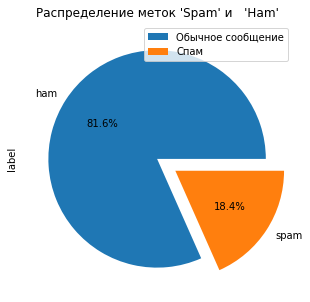

In [87]:
df["label"].value_counts().plot(kind = 'pie',explode=[0, 0.2],figsize=(5, 5),autopct='%1.1f%%')
plt.title("Распределение меток 'Spam' и   'Ham'")
plt.legend(["Обычное сообщение", "Спам"]);

Видим, что обычных сообщений сильно больше, чем спама.

Рассмотрим частотное распределение длины сообщения:

In [88]:
df['message len'] = df['message'].apply(str).apply(len)
df.head()

,message,label,message len
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,spam,1111
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam,753
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam,610
3,##############################################...,spam,2863
4,I thought you might like these:\n1) Slim Down ...,spam,641


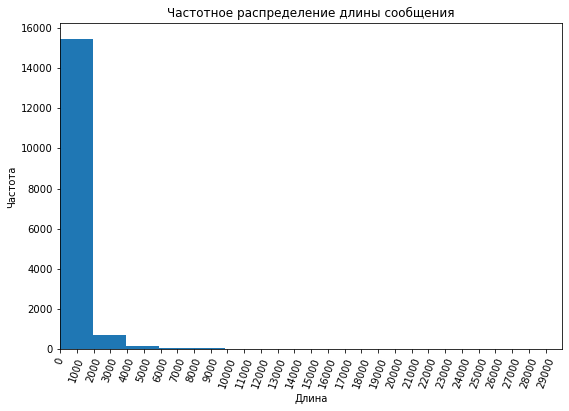

In [89]:
fig, ax = plt.subplots(figsize=(9,6))
df['message len'].plot(bins=99, kind='hist')
plt.title("Частотное распределение длины сообщения")
ax.set_xlim((-0.5, 30_000))
plt.xticks(range(0, 30_000, 1000), rotation=70)
plt.xlabel("Длина")
plt.ylabel("Частота");

Чаще всего встречаются сообщения длиной в промежутке примерно от 2 до 2000 симловов

In [90]:
df['message len'].describe()

count     16633.000000
mean        691.121986
std        3085.682232
min           1.000000
25%          45.000000
50%         115.000000
75%         553.000000
max      194978.000000
Name: message len, dtype: float64

Всего в датасете 16633 сообщения;\
Средняя длина сообщения составляет примерно 691 символов;\
Минимальная длина сообщения составляет 1 символ;\
Максимальная длина сообщения составляет 194978 символов

Теперь посмотрим частотные распределения длин сообщений по отдельности:

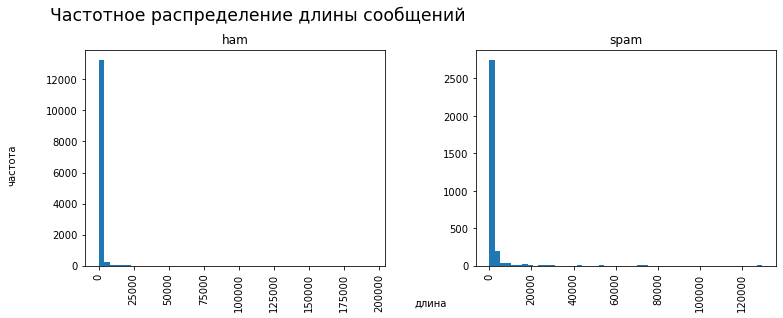

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
df.hist(column='message len', by='label', bins=50,figsize=(40,50), ax=axes)
plt.suptitle('Частотное распределение длины сообщений', x=0.3, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.01, 'длина', ha='center')
fig.text(0.01, 0.5, 'частота', va='center', rotation='vertical');

In [92]:
df[['label', 'message len']].groupby('label').describe()

message len                                                       \
            count         mean          std  min    25%    50%     75%   
label                                                                    
ham       13580.0   568.019661  2810.077092  2.0   39.0   80.0   344.0   
spam       3053.0  1238.691451  4048.052505  1.0  148.0  173.0  1096.0   

                 
            max  
label            
ham    194978.0  
spam   129635.0

Теперь можно сравнить характеристики обычных сообщений и сообщений со спамом:\
средняя длина спам сообщения почти в два раза больше, чем средняя длина обычного сообщения;\
для сообщений со спамом характерно большое в сравнении с обычным сообщениями отклонение от средней длины;
минимальная длина сообщения со спамом ниже, чем обычного;\
максимальная длина сообщения со спамом ниже, чем обычного

**4. Предобработка данных**

Сначала нужно подготовить текст к работе. \
Это включает в себя:
1. Приведение текста к нижнему регистру
2. Очистка от пунктуации
3. Очистка стоп-слов (то есть, те слова, которые наиболее часто встречаются) 
4. Токенизация

Заметим, что все сообщения в датасете являются предложениями на английском языке. 

In [93]:
stopwords = nltk.corpus.stopwords.words('english')

In [94]:
spam_m = df[df["label"] == "spam"]["message"].apply(str)
ham_m = df[df["label"] == "ham"]["message"].apply(str)

Напишем функцию $preprocess$_$text$, которая уберет все знаки пунктуации, стоп-слова, небуквенные символы и  приведет к нижнему регистру, и будет возвращать список подходящих значений

In [95]:
def remove_pun(text):
    text = re.sub(r'[^a-zA-Zа-яЁА-ЯЁ ]', '', text)
    text = text.lower()
    return ' '.join(list(set(text.split(' '))))

In [96]:
import re
def preprocess_text(df):
    def remove_pun(text):
        text = re.sub(r'[^a-zA-Zа-яЁА-ЯЁ ]', '', text)
        text = text.lower()
        return ' '.join(list(set(text.split(' '))))
    all_words = " ".join(df.apply(remove_pun)).split()
    nonstops = [word for word in all_words if word not in stopwords and word.isalpha()]
    return nonstops

In [97]:
spam_w = preprocess_text(spam_m)

In [98]:
ham_w = preprocess_text(ham_m)

Продолжим анализ данных уже после предобработки.

Посмотрим ТОП частых слов в спаме и нет.

Для спама:

In [101]:
from nltk.probability import FreqDist
spamdist = FreqDist(spam_w)
spamdist

FreqDist({'free': 999, 'email': 914, 'call': 879, 'please': 794, 'click': 775, 'get': 727, 'new': 569, 'list': 556, 'us': 541, 'one': 508, ...})

Частые слова: call, free, txt

Для обычных сообщений:

In [102]:
hamdist = FreqDist(ham_w)
hamdist

FreqDist({'im': 1705, 'get': 1701, 'u': 1542, 'one': 1482, 'dont': 1450, 'like': 1439, 'time': 1211, 'wrote': 1180, 'know': 1150, 'mailing': 1130, ...})

Частые слова: u, im, get

Посмотрим на распределение слова в зависимости от их использование в тексте.

Спам:

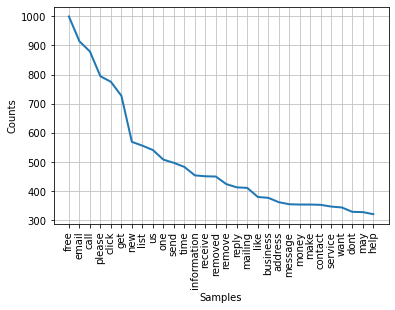

In [103]:
spamdist.plot(30,cumulative=False);

Обычные сообщения:

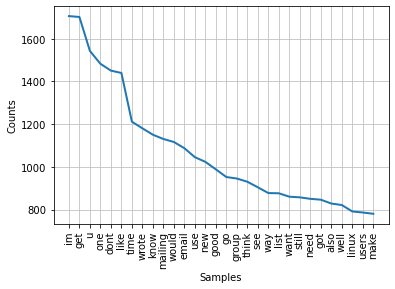

In [104]:
hamdist.plot(30,cumulative=False);

Создадим облако слов для наглядности:

In [105]:
from wordcloud import WordCloud as wc

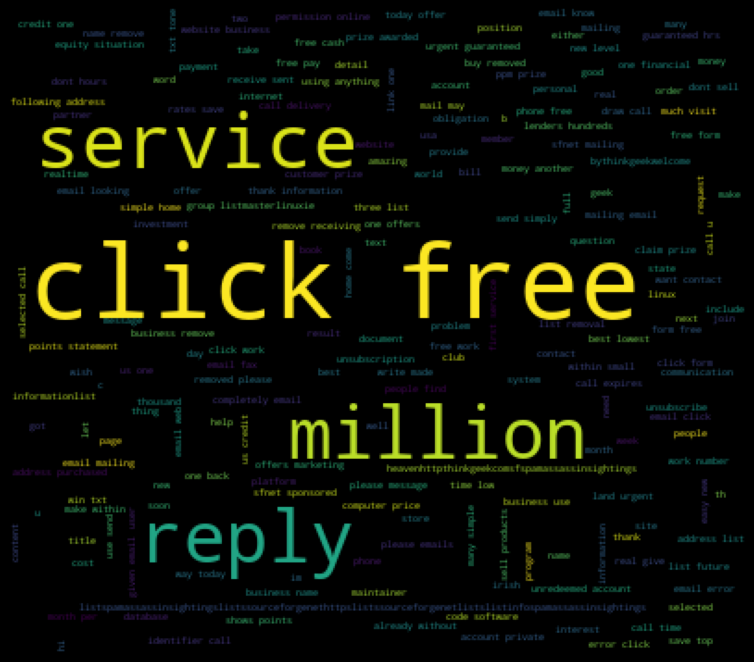

In [110]:
spam_cloud = wc(width=400, height=350).generate(' '.join(spam_w))
plt.figure( figsize=(11,9), facecolor='k')
plt.imshow(spam_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Неудивительно, что в спаме самые частые слова это: call, free, txt и др.

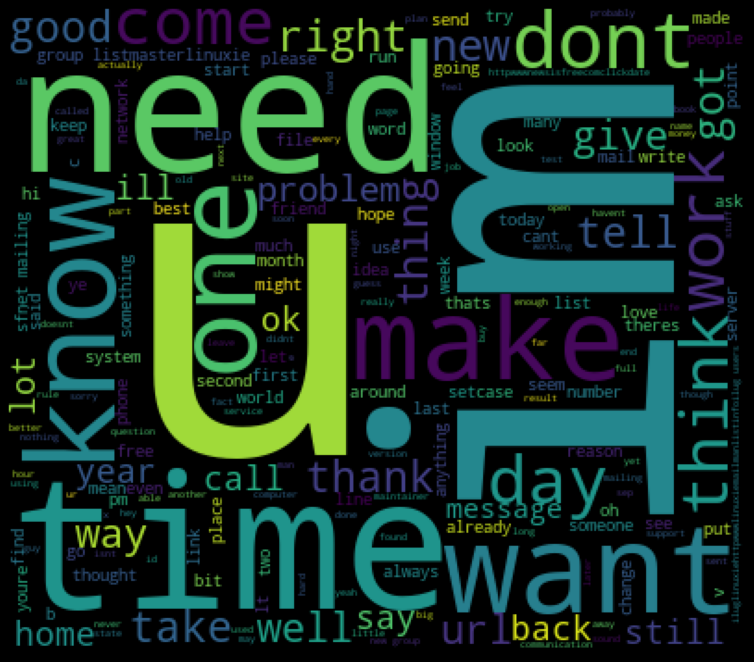

In [107]:
ham_cloud = wc(width=400, height=350).generate(' '.join(ham_w))
plt.figure( figsize=(11,9), facecolor='k')
plt.imshow(ham_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

В обычных сообщениях часто встречаются im, ok, u\
Здесь заметен эффект сленга: некоторые стоп-слова содержатся в видоизмененных формах и потому не убрались из данных.

В качестве примера классифицируем сообщения на спам и нет при помощи моделей классификации.

Преобразуем данные к удобному для классификацию типу данных:\
заменим строковые метки на численные и обработаем текстовые данные, убрав из них пунктуацию, небуквенные символы и стоп-слова.

In [111]:
df['label'] = df['label'].replace('ham', 0)
df['label'] = df['label'].replace('spam', 1)
df.head()

,message,label,message len
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610
3,##############################################...,1,2863
4,I thought you might like these:\n1) Slim Down ...,1,641


In [112]:
def preprocess_text2(text):
    text = re.sub(r'[^a-zA-Zа-яЁА-ЯЁ ]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

In [113]:
df['message'] = df['message'].apply(str).apply(preprocess_text2)

In [114]:
df.head()

,message,label,message len
0,save life insurancewhy spend tolife quote savi...,1,1111
1,fight risk cancerhttpwwwadclickwspcfmospk slim...,1,753
2,fight risk cancerhttpwwwadclickwspcfmospk slim...,1,610
3,adult club offers free membership instant acce...,1,2863
4,thought might like slim guaranteed lose lbs da...,1,641


В сообщениях много сокращений таких, как, например, 'idk', означающее 'i don't know'. Несмотря на большие возможности нормализации текста, ни стемминг, ни леммтизация в случае с сокращениями не поможет.\
Попробуем обучить модель, подав ей данные такие, какие мы получили на данном этапе.

При первичной загрузке датасетов было заметно, что в некоторых строках содержатся странные значения, например, большое число решеток "#" и других символов. Проверим, не осталось ли после обработки пустых строк:

In [115]:
df['message'][df['message']==''].count()

17

Удалим строки, где остались сообщения нулевой длины, то есть без символов:

In [116]:
df[df['message']==''] = np.nan

In [117]:
df = df.dropna()

In [118]:
# проверка
df['message'][df['message']==''].count()

0

**5. Векторизация**

Воспользуемся встроенным TF-IDF векторизатором:

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['message'])
vectors.shape

(16616, 107396)

In [120]:
features = vectors

**6. Разбиение данных на обучающую, тестовую выборки**

Теперь разобьем данные на обучающую и тестовую выборки в соотношении 80:20.

In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, df['label'], test_size=0.2, random_state=76)

In [122]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(13292, 107396)
(3324, 107396)
(13292,)
(3324,)


**7. Обучение моделей**

Для задачи классификации воспользуемся такими алгоритмами как:
1. Логистическая регрессия
2. Метод опорных векторов
3. k- ближайших соседей, где k=49
4. Наивный метод Байеса
5. Дерево решений
6. Случайный лес

Импортируем модели:

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

Воспользуемся конструктором класса для создания моделей:

In [124]:
svc = SVC(kernel='sigmoid')
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=72)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=72)

Создадим словарь с названиями моделей и самими моделями:

In [125]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}
def train(clf, features, targets):
    """обучает модели"""
    clf.fit(features, targets)

def predict(clf, features):
    """делает предсказания"""
    return (clf.predict(features))

В цикле обучим все модели и сохраним метрику accuracy:

In [126]:
from sklearn.metrics import accuracy_score, confusion_matrix
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    y_pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, accuracy_score(y_test , y_pred)))

**8. Выводы о проделанных алгоритмах, выбор наиболее эффективного**

Для удобного прочтения результатов создадим табличку со всеми результатами:

In [127]:
predictions = pd.DataFrame(pred_scores_word_vectors, columns=['model', 'score'])
predictions

,model,score
0,SVC,0.979242
1,KN,0.941637
2,NB,0.980746
3,DT,0.967509
4,LR,0.957581
5,RF,0.978941


Алгоритм Наивного Байеса оказался наиболее удачным.

Проверим на переобучение модель:

In [131]:
mnb = MultinomialNB(alpha=0.2).fit(X_train, y_train)
y_pred = mnb.predict(X_test)
y_train_pred = mnb.predict(X_train)
print(f"Training score: {accuracy_score(y_train, y_train_pred)}")
print(f"Test score: {accuracy_score(y_test, y_pred)}")

Training score: 0.9897682816731869
Test score: 0.9807460890493381


Видно, что обе метрики имеют высокие показатели и между ними нет большого разрыва.\
Можно предположить, что переобучения нет.

**9. Визуализация результатов**

Посмотрим для самой удачной модели еще одну метрику:

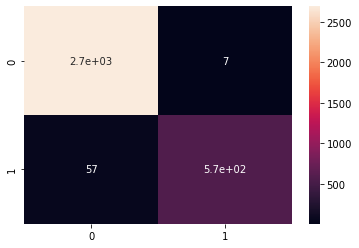

In [129]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True);

Учитывая объемы данных, можно утверждать, что модель достаточно хорошо классифицирует сообщения:\
на 2700 правильно предсказанных обычных сообщений приходится 57 неправильно предсказаных. И на 550 правильно предсказанных спам-сообщений приходится 7 ошибок. Модель немного чаще ошибается в определении обычных сообщений, иногда классифицируя их как спам.

### Выводы

В ходе работы был проделан статистический анализ данных с сообщениями, где содержатся сообщения со спамом и без спама.\
Большую часть данных занимают сообщения без спама, они составляют 81,6% от всего датасета.\
Все длины сообщений находятся в диапазоне от 1 до 194978 символов, а средняя длина сообщения составляет примерно 691 символ. Длинные сообщения, длиной свыше 129635 символа, встречаются исключительно в обычных сообщениях.\
Короткие сообщения, длиной менее 13 символов, встречаются как в спаме, так и в обычных сообщениях.\
Характерной чертой обычных сообщений является наличие сокращений и сленга. Эти же слова являются наиболее часто используемыми.
Для спам-сообщений характерны слова, призывающие перезвонить, написать, перейти по ссылке, слова, связанные с призом или подарком. На первом месте по частоте использования встречается слово "free" (бесплатный). Не менее редкий является слово "call" (позвонить), "click" (перейти по ссылке) и т.п., что неудивительно для сообщений со спамом.

В качестве примера были обучены несколько моделей классификации. Среди них были:
1. Логистическая регрессия
2. Метод опорных векторов
3. k- ближайших соседей
4. Наивный метод Байеса
5. Дерево решений
6. Случайный лес

Все они показали высокие метрики эффективности. Для дальнейшего анализа была выбрана модель с самой высокой метрикой эффективности - алгоритм Наивного Байеса, с accuracy = 0.980746.\
Модель показала хорошие результаты. Было выявлено, что  модель немного чаще ошибается в определении обычных сообщений, иногда классифицируя их как спам.